In [29]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

pd.set_option("display.max_columns", None)
np.set_printoptions(suppress=True)
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [30]:
DATA_DIR = Path("../../../data")
RAW_DIR = DATA_DIR / "raw"
ML_DIR = DATA_DIR / "ml"

print("Carregando bases brutas...")
df_facas = pd.read_parquet(RAW_DIR / "tb_facas.parquet")
df_cv = pd.read_parquet(ML_DIR / "table_final_cv.parquet")
df_pedidos = pd.read_parquet("tb_pedidos_process.parquet")

print(f"tb_facas: {df_facas.shape}")
print(f"table_final_cv: {df_cv.shape}")
print(f"tb_pedidos_process: {df_pedidos.shape}")


Carregando bases brutas...
tb_facas: (8180, 4)
table_final_cv: (164461, 8)
tb_pedidos_process: (150596, 52)


In [31]:
# Merge das bases
df_cv_pedidos = (
    df_cv.merge(df_pedidos, on=["CD_OP"], how="inner")
    .merge(df_facas[["CD_FACA", "VL_COMPLAMINA"]], on="CD_FACA", how="left")
    .drop(columns="TX_TIPO_MAQUINA")
)

# Preencher VL_COMPLAMINA faltante
df_cv_pedidos["VL_COMPLAMINA"] = df_cv_pedidos["VL_COMPLAMINA"].fillna(0)

print(f"Registros após merge: {df_cv_pedidos.shape[0]:,}")
print(f"Colunas disponíveis: {df_cv_pedidos.shape[1]}")


Registros após merge: 78,684
Colunas disponíveis: 59


In [32]:
print("Criando features derivadas...")

# Aspect ratios (proporções)
df_cv_pedidos["RAZAO_COMP_LARG"] = df_cv_pedidos[
    "VL_COMPRIMENTO"
] / df_cv_pedidos["VL_LARGURA"].replace(0, np.nan)
df_cv_pedidos["RAZAO_INTERNA"] = df_cv_pedidos[
    "VL_COMPRIMENTOINTERNO"
] / df_cv_pedidos["VL_LARGURAINTERNA"].replace(0, np.nan)

# Volumes e áreas
df_cv_pedidos["VOLUME_INTERNO"] = (
    df_cv_pedidos["VL_COMPRIMENTOINTERNO"]
    * df_cv_pedidos["VL_LARGURAINTERNA"]
    * df_cv_pedidos["VL_ALTURAINTERNA"]
)
df_cv_pedidos["AREA_CHAPA"] = (
    df_cv_pedidos["VL_COMPRIMENTO"] * df_cv_pedidos["VL_LARGURA"]
)

# Peças por chapa (aproveitamento)
df_cv_pedidos["PECAS_POR_CHAPA"] = (
    df_cv_pedidos["VL_MULTCOMP"] * df_cv_pedidos["VL_MULTLARG"]
)

# Total de refilo (desperdício)
df_cv_pedidos["REFILO_TOTAL"] = (
    df_cv_pedidos["VL_REFILOCOMPRIMENTO"] + df_cv_pedidos["VL_REFILOLARGURA"]
)

print(f"Features criadas. Shape atual: {df_cv_pedidos.shape}")
print(f"\nNovas colunas adicionadas:")
new_cols = [
    "RAZAO_COMP_LARG",
    "RAZAO_INTERNA",
    "VOLUME_INTERNO",
    "AREA_CHAPA",
    "PECAS_POR_CHAPA",
    "REFILO_TOTAL",
]
for col in new_cols:
    print(f"  - {col}")


Criando features derivadas...
Features criadas. Shape atual: (78684, 64)

Novas colunas adicionadas:
  - RAZAO_COMP_LARG
  - RAZAO_INTERNA
  - VOLUME_INTERNO
  - AREA_CHAPA
  - PECAS_POR_CHAPA
  - REFILO_TOTAL


In [33]:
df_cv_pedidos.describe()

,QT_PRODUZIDA,QT_CHAPASALIMENTADAS,VL_DURACAO_PRODUCAO,QT_PROGRAMADA,VL_DURACAO_PARADAS,QT_PARADAS,PERC_VAR_PEDIDA,QT_ARRANJO,VL_COBBINTMAXIMO,QT_NRCORES,QT_PEDIDA,VL_ALTURAINTERNA,VL_AREALIQUIDAPECA,VL_COLUNAMINIMO,VL_COMPPECA,VL_COMPRESSAO,VL_COMPRIMENTO,VL_COMPRIMENTOINTERNO,VL_GRAMATURA,VL_LAP,FL_LAP_INTERNO,FL_LAP_NO_COMPR,VL_LARGPECA,VL_LARGURA,VL_LARGURAINTERNA,VL_MULTCOMP,VL_MULTLARG,VL_PESOCAIXA,VL_PESOPECA,VL_REFILOCOMPRIMENTO,VL_REFILOLARGURA,VL_REFUGOCLIENTE,VL_VINCOCOMP1,VL_VINCOCOMP2,VL_VINCOCOMP3,VL_VINCOCOMP4,VL_VINCOCOMP5,VL_VINCOLARG1,VL_VINCOLARG2,VL_VINCOLARG3,VL_CONSUMO_COR_TOTAL,FL_PROLONGLAP,VL_VINCOS_TOTAL_MM,RAZAO_CHAPA_COMP_LARG,RAZAO_PECA_COMP_LARG,VOLUME_INTERNO,VL_COMPLAMINA,RAZAO_COMP_LARG,RAZAO_INTERNA,AREA_CHAPA,PECAS_POR_CHAPA,REFILO_TOTAL
count,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,78684.000000,7.868400e+04,78684.000000,78684.000000,78684.000000,7.868400e+04,78684.000000,78684.000000
mean,13221.014971,3969.614750,77.821692,13123.934396,36.450981,5.250966,4.716319,3.383407,30.286945,1.403246,13216.695402,123.078974,0.499113,6.196880,652.716232,10.465635,1957.045066,515.595356,461.556022,0.376442,0.021987,0.000292,786.323064,839.948973,339.021300,3.198744,1.070345,235.964554,38.689543,12.535407,17.846754,3.793740,0.101037,1.817117,2.368830,0.157364,0.359069,2.316672,1.629823,0.278138,460.464605,0.002072,9.028049,2.449967,0.872719,2.216172e+07,19148.590044,2.449967,1.566377,1.628084e+06,3.383407,30.382162
std,11645.580454,3111.004425,81.628962,11638.839308,62.834741,5.692544,2.391123,1.111556,13.624273,0.881676,11520.869588,58.172981,0.253912,1.522206,205.394608,54.520938,315.265383,150.580811,96.320089,3.530700,0.146641,0.017095,188.834140,190.160840,110.039509,0.935132,0.269096,157.082606,113.812968,3.792705,6.402907,4.503159,1.945121,38.431732,47.662434,5.851302,12.700078,40.654475,27.004119,7.606069,765.166703,0.045468,155.946832,0.662733,0.398396,3.678674e+07,4149.270046,0.662733,0.585046,3.788101e+05,1.111556,8.489296
min,0.000000,0.000000,0.000000,-1750.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,50.000000,0.000000,0.061004,0.000000,157.000000,0.000000,656.000000,190.000000,0.000000,0.000000,0.000000,0.000000,235.000000,332.000000,88.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.296356,0.072742,0.000000e+00,0.000000,0.296356,0.503979,3.175070e+05,1.000000,0.000000
25%,6000.000000,1822.000000,32.000000,6000.000000,6.000000,2.000000,3.000000,3.000000,18.000000,1.000000,6000.000000,90.000000,0.382282,5.000000,551.000000,0.000000,1738.000000,424.000000,416.000000,0.000000,0.000000,0.000000,685.000000,729.000000,300.000000,2.000000,1.000000,164.000000,0.000000,10.000000,15.000000,1.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,1.898032,0.721333,1.559250e+07,17122.000000,1.898032,1.409836,1.359666e+06,3.000000,25.000000
50%,9600.000000,3000.000000,59.000000,9600.000000,24.000000,4.000000,4.000000,3.000000,30.000000,1.000000,9600.000000,119.000000,0.420369,6.000000,596.000000,0.000000,2002.000000,565.000000,446.000000,0.000000,0.000000,0.000000,772.000000,807.000000,360.000000,3.000000,1.000000,195.000000,0.000000,10.000000,15.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,86.000000,0.000000,0.000000,2.519112,0.761404,1.837462e+07,19

In [ ]:
# Colunas a excluir
colunas_excluir = [
    # Identificadores
    "CD_OP",
    "CD_ITEM",
    "CD_PEDIDO",
    "CD_FACA",
    # Variáveis target (resultados de produção)
    "QT_PRODUZIDA",
    "QT_CHAPASALIMENTADAS",
    "VL_DURACAO_PRODUCAO",
    "QT_PROGRAMADA",
    "VL_DURACAO_PARADAS",
    "QT_PARADAS",
    # Categóricas de alta cardinalidade (analisar DEPOIS do clustering)
    "CAT_COMPOSICAO",
    "TX_TIPOABNT",
    "VL_MULTCOMP",
    "VL_MULTLARG",
    "FL_REFILADO",
    "PECAS_POR_CHAPA",
    "QT_ARRANJO",
    # Redundante com VL_COMPRIMENTO
    "VL_COMPRIMENTO",  # 0.9999 correlação
    # Redundante com VL_LARGURA
    "VL_LARGURA",  # 0.9999 correlação
    # Redundante com RAZAO_COMP_LARG
    "RAZAO_PECA_COMP_LARG",  # 0.9999 correlação
    "RAZAO_CHAPA_COMP_LARG",  # 0.9999 correlação
    # Redundante com AREA_CHAPA ou VL_AREALIQUIDAPECA
    # 'AREA_CHAPA',  # Manter uma das duas
    "VL_AREALIQUIDAPECA",  # Remover (AREA_CHAPA é mais interpretável)
    # # Vincos individuais - usar só VL_VINCOS_TOTAL_MM
    # "VL_VINCOCOMP1",
    # "VL_VINCOCOMP2",
    # "VL_VINCOCOMP3",
    # "VL_VINCOCOMP4",
    # "VL_VINCOCOMP5",
    # "VL_VINCOLARG1",
    # "VL_VINCOLARG2",
    # "VL_VINCOLARG3",
    # Redundante com VL_REFILOCOMPRIMENTO
    "REFILO_TOTAL",
    "AREA_CHAPA",
    "VL_VINCOS_TOTAL_MM",
    "VL_COMPRIMENTOINTERNO",
    "VL_ALTURAINTERNA",
    "VL_LARGURAINTERNA",
    "PECAS_POR_CHAPA",
    "VL_PESOPECA",
    "VL_REFILOCOMPRIMENTO",
    "VL_PESOCAIXA",
]

# Features para clusterização
features_clustering = [
    col for col in df_cv_pedidos.columns if col not in colunas_excluir
]

print(f"Total de features para clusterização: {len(features_clustering)}")
print(f"\nFeatures selecionadas:")
for i, feat in enumerate(features_clustering, 1):
    print(f"  {i:2d}. {feat}")


col_fl = [
    "FL_TESTE_EXIGELAUDO",
    "FL_RESINAINTERNA",
    "FL_CONTROLE_ESPECIAL_IMPRESSAO",
]

df_cv_pedidos[col_fl] = df_cv_pedidos[col_fl].astype(int)
df_cluster = df_cv_pedidos[features_clustering].copy()


Total de features para clusterização: 33

Features selecionadas:
   1. CAT_ESPELHO
   2. CAT_FILME
   3. FL_CONTROLE_ESPECIAL_IMPRESSAO
   4. FL_TESTE_EXIGELAUDO
   5. FL_RESINAINTERNA
   6. PERC_VAR_PEDIDA
   7. VL_COBBINTMAXIMO
   8. QT_NRCORES
   9. QT_PEDIDA
  10. VL_COLUNAMINIMO
  11. VL_COMPPECA
  12. VL_COMPRESSAO
  13. VL_GRAMATURA
  14. VL_LAP
  15. FL_LAP_INTERNO
  16. FL_LAP_NO_COMPR
  17. VL_LARGPECA
  18. VL_REFILOLARGURA
  19. VL_REFUGOCLIENTE
  20. VL_VINCOCOMP1
  21. VL_VINCOCOMP2
  22. VL_VINCOCOMP3
  23. VL_VINCOCOMP4
  24. VL_VINCOCOMP5
  25. VL_VINCOLARG1
  26. VL_VINCOLARG2
  27. VL_VINCOLARG3
  28. VL_CONSUMO_COR_TOTAL
  29. FL_PROLONGLAP
  30. VOLUME_INTERNO
  31. VL_COMPLAMINA
  32. RAZAO_COMP_LARG
  33. RAZAO_INTERNA


In [35]:
col_fl = [
    "FL_TESTE_EXIGELAUDO",
    "FL_RESINAINTERNA",
    "FL_CONTROLE_ESPECIAL_IMPRESSAO",
]

df_cv_pedidos[col_fl] = df_cv_pedidos[col_fl].astype(int)
df_cluster = df_cv_pedidos[features_clustering].copy()


In [36]:
# Criar dataset para clustering

# Converter categóricas para object (para one-hot encoding)
df_cluster[["CAT_ESPELHO", "CAT_FILME"]] = df_cluster[
    ["CAT_ESPELHO", "CAT_FILME"]
].astype("object")

print(f"\nShape do dataset de clustering: {df_cluster.shape}")



Shape do dataset de clustering: (78684, 33)


In [37]:
# Separar features numéricas e categóricas
features_numericas = df_cluster.select_dtypes(include=[np.number]).columns.tolist()
features_categoricas = df_cluster.select_dtypes(
    include=["object", "category"]
).columns.tolist()

print(f"Features numéricas: {len(features_numericas)}")
print(f"Features categóricas: {len(features_categoricas)}")
print(f"\nCategoricas: {features_categoricas}")


Features numéricas: 31
Features categóricas: 2

Categoricas: ['CAT_ESPELHO', 'CAT_FILME']


In [38]:
# 1. Tratamento de missing values
missing = df_cluster[features_numericas].isnull().sum().sum()
if missing > 0:
    print(f"Preenchendo {missing} missing values com mediana...")
    df_cluster[features_numericas] = df_cluster[features_numericas].fillna(
        df_cluster[features_numericas].median()
    )
else:
    print("✓ Nenhum missing value encontrado")

# 2. One-hot encoding de categóricas
if len(features_categoricas) > 0:
    print(f"\nAplicando One-Hot Encoding em {len(features_categoricas)} features...")
    df_cluster_encoded = pd.get_dummies(
        df_cluster, columns=features_categoricas, drop_first=True
    )
else:
    df_cluster_encoded = df_cluster.copy()

print(f"Shape após encoding: {df_cluster_encoded.shape}")


✓ Nenhum missing value encontrado

Aplicando One-Hot Encoding em 2 features...
Shape após encoding: (78684, 38)


In [39]:
# 3. Normalização com StandardScaler
print("\nAplicando StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_encoded)

print(f"Dados normalizados: {X_scaled.shape}")
print(f"Média ~0: {X_scaled.mean():.4f}")
print(f"Std ~1: {X_scaled.std():.4f}")



Aplicando StandardScaler...
Dados normalizados: (78684, 38)
Média ~0: -0.0000
Std ~1: 1.0000


In [40]:
# 4. PCA para redução de dimensionalidade
print("\nAplicando PCA (95% da variância)...")
pca_reducer = PCA(n_components=0.95, random_state=42)
X_pca = pca_reducer.fit_transform(X_scaled)

print(f"Dimensões reduzidas: {X_scaled.shape[1]} → {X_pca.shape[1]}")
print(f"Variância explicada: {pca_reducer.explained_variance_ratio_.sum():.2%}")
print(f"Componentes principais: {pca_reducer.n_components_}")

# Dataset final para clustering
X_final = X_pca
print(f"\n✓ Dataset pronto para GMM: {X_final.shape}")



Aplicando PCA (95% da variância)...
Dimensões reduzidas: 38 → 25
Variância explicada: 95.56%
Componentes principais: 25

✓ Dataset pronto para GMM: (78684, 25)


In [41]:
# Testar diferentes valores de K
K_range = range(2, 11)
bic_scores = []
aic_scores = []
silhouette_scores = []

print("Testando GMM com diferentes valores de K...")
print(f"{'K':>3} | {'BIC':>12} | {'AIC':>12} | {'Silhouette':>10}")
print("-" * 50)

for k in K_range:
    gmm = GaussianMixture(
        n_components=k, covariance_type="full", random_state=42, n_init=3, max_iter=100
    )
    gmm.fit(X_final)

    # Calcular métricas
    bic = gmm.bic(X_final)
    aic = gmm.aic(X_final)
    labels = gmm.predict(X_final)
    sil = silhouette_score(X_final, labels)

    bic_scores.append(bic)
    aic_scores.append(aic)
    silhouette_scores.append(sil)

    print(f"{k:3d} | {bic:12,.0f} | {aic:12,.0f} | {sil:10.4f}")

# Melhor K
best_k_bic = K_range[np.argmin(bic_scores)]
best_k_aic = K_range[np.argmin(aic_scores)]
best_k_sil = K_range[np.argmax(silhouette_scores)]

print("\n" + "=" * 50)
print(f"Melhor K por BIC (menor): {best_k_bic}")
print(f"Melhor K por AIC (menor): {best_k_aic}")
print(f"Melhor K por Silhouette (maior): {best_k_sil}")
print("=" * 50)


Testando GMM com diferentes valores de K...
  K |          BIC |          AIC | Silhouette
--------------------------------------------------
  2 |   -1,517,642 |   -1,524,142 |     0.4293
  3 |   -4,693,648 |   -4,703,403 |     0.1761
  4 |   -5,031,259 |   -5,044,269 |     0.1666
  5 |   -5,458,290 |   -5,474,555 |     0.1752
  6 |   -5,338,699 |   -5,358,219 |     0.1842
  7 |   -5,408,904 |   -5,431,679 |     0.1941


KeyboardInterrupt: 

In [43]:
# Escolher K ótimo (usar BIC como critério principal)
K_optimal = 5
print(f"\n K ÓTIMO ESCOLHIDO: {K_optimal} (baseado no BIC)")



 K ÓTIMO ESCOLHIDO: 5 (baseado no BIC)


In [44]:
%%time
# Treinar GMM final
print(f"Treinando GMM com K={K_optimal}...")
gmm_final = GaussianMixture(
    n_components=K_optimal,
    covariance_type="full",
    random_state=42,
    n_init=10,
    max_iter=100,
)
gmm_final.fit(X_final)

print(f"\n✓ Modelo GMM treinado com sucesso!")
print(f"  Convergiu: {gmm_final.converged_}")
print(f"  Iterações: {gmm_final.n_iter_}")
print(f"  Log-likelihood: {gmm_final.score(X_final) * len(X_final):,.0f}")


Treinando GMM com K=5...

✓ Modelo GMM treinado com sucesso!
  Convergiu: True
  Iterações: 10
  Log-likelihood: 2,739,032
CPU times: user 3min 58s, sys: 297 ms, total: 3min 58s
Wall time: 34.1 s


In [46]:
# Obter labels e probabilidades
cluster_labels = gmm_final.predict(X_final)
cluster_probs = gmm_final.predict_proba(X_final)

# Adicionar ao dataframe original
df_cv_pedidos["CLUSTER_PRODUTO"] = cluster_labels

# Adicionar probabilidades de cada cluster
for k in range(K_optimal):
    df_cv_pedidos[f"PROB_CLUSTER_{k}"] = cluster_probs[:, k]

# Calcular entropia (incerteza do clustering)
entropy = -np.sum(cluster_probs * np.log(cluster_probs + 1e-10), axis=1)
df_cv_pedidos["CLUSTER_ENTROPY"] = entropy

print("\nDistribuição dos Clusters:")
print(df_cv_pedidos["CLUSTER_PRODUTO"].value_counts().sort_index())

print(f"\nEntropia média: {entropy.mean():.4f}")
print(
    f"  Baixa entropia (<0.5): {(entropy < 0.5).sum():,} OPs ({(entropy < 0.5).sum() / len(entropy) * 100:.1f}%)"
)
print(
    f"  Alta entropia (>1.0): {(entropy > 1.0).sum():,} OPs ({(entropy > 1.0).sum() / len(entropy) * 100:.1f}%)"
)



Distribuição dos Clusters:
CLUSTER_PRODUTO
0     6863
1    49896
2    18900
3      150
4     2875
Name: count, dtype: int64

Entropia média: 0.0001
  Baixa entropia (<0.5): 78,681 OPs (100.0%)
  Alta entropia (>1.0): 0 OPs (0.0%)


In [ ]:
# Visualização da distribuição
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Distribuição de OPs por cluster
cluster_counts = df_cv_pedidos["CLUSTER_PRODUTO"].value_counts().sort_index()
bars = ax1.bar(
    cluster_counts.index, cluster_counts.values, color=plt.cm.Set3(range(K_optimal))
)
ax1.set_xlabel("Cluster", fontsize=12)
ax1.set_ylabel("Quantidade de OPs", fontsize=12)
ax1.set_title(
    f"Distribuição de OPs por Cluster (K={K_optimal})", fontsize=14, fontweight="bold"
)
ax1.set_xticks(range(K_optimal))

for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Histograma de entropia
ax2.hist(entropy, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
ax2.axvline(
    entropy.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Média: {entropy.mean():.3f}",
)
ax2.set_xlabel("Entropia", fontsize=12)
ax2.set_ylabel("Frequência", fontsize=12)
ax2.set_title("Distribuição da Incerteza (Entropia)", fontsize=14, fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("gmm_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✓ Gráfico salvo: gmm_distribution.png")


In [47]:
# Features principais para análise
features_perfil = [
    "VL_COMPRIMENTO",
    "VL_LARGURA",
    "VL_ALTURAINTERNA",
    "VL_GRAMATURA",
    "QT_NRCORES",
    "VL_AREALIQUIDAPECA",
    "VL_MULTCOMP",
    "VL_MULTLARG",
    "PECAS_POR_CHAPA",
    "VL_VINCOS_TOTAL_MM",
    "VL_CONSUMO_COR_TOTAL",
    "VOLUME_INTERNO",
    "AREA_CHAPA",
    "REFILO_TOTAL",
]

# Calcular perfil médio
cluster_profiles_mean = df_cv_pedidos.groupby("CLUSTER_PRODUTO")[features_perfil].mean()

print("Perfil dos Clusters (médias):")
print("=" * 100)
print(cluster_profiles_mean.round(2))

# Salvar
cluster_profiles_mean.to_csv("gmm_cluster_profiles.csv")
print("\n✓ Perfil salvo: gmm_cluster_profiles.csv")


Perfil dos Clusters (médias):
                 VL_COMPRIMENTO  VL_LARGURA  VL_ALTURAINTERNA  VL_GRAMATURA  \
CLUSTER_PRODUTO                                                               
0                       1847.24      885.10            124.61        388.19   
1                       1945.61      840.98            119.37        458.88   
2                       2002.96      821.15            117.43        479.71   
3                       1964.00     1292.00            850.00        840.00   
4                       2115.39      814.24            183.08        543.95   

                 QT_NRCORES  VL_AREALIQUIDAPECA  VL_MULTCOMP  VL_MULTLARG  \
CLUSTER_PRODUTO                                                             
0                      2.07                0.59         3.15         1.05   
1                      1.32                0.49         3.15         1.09   
2                      1.30                0.49         3.29         1.02   
3                      1.00    

In [48]:
# Análise de categóricas (que foram excluídas do clustering)
print("\n" + "=" * 100)
print("Características Categóricas por Cluster:")
print("=" * 100)

categoricas_analise = ["CAT_COMPOSICAO", "CAT_ESPELHO", "CAT_FILME", "TX_TIPOABNT"]

for col in categoricas_analise:
    if col in df_cv_pedidos.columns:
        print(f"\n{col}:")
        crosstab = (
            pd.crosstab(
                df_cv_pedidos["CLUSTER_PRODUTO"],
                df_cv_pedidos[col],
                normalize="index",
            )
            * 100
        )
        print(crosstab.round(1))



Características Categóricas por Cluster:

CAT_COMPOSICAO:
CAT_COMPOSICAO   A1-B  A1-D  A1-DC  A10-B  A10-C  A10KC-C  A10S-B  A10S-C  \
CLUSTER_PRODUTO                                                             
0                 9.4  14.8    0.1    2.1    1.9      0.0     0.0     0.0   
1                 7.0   3.0    0.1    4.5    4.1      0.0     1.0     2.3   
2                 2.8   0.5    0.0    7.4    4.7      0.0     1.5     1.5   
3                 0.0   0.0    0.0    0.0    0.0      0.0     0.0     0.0   
4                 0.0   0.0    0.0    0.2   68.0      0.0     0.0     0.3   

CAT_COMPOSICAO   A12-B  A12-C  A15-B  A15-C  A18-B  A18-C  A2-B  A2-DC  A2G-B  \
CLUSTER_PRODUTO                                                                 
0                  2.9    0.7    1.0    3.9    0.3    0.1   5.2    0.2    0.0   
1                  3.2    2.0    2.3    1.7    0.0    3.4   5.4    0.0    0.0   
2                  4.6    0.1    1.0    1.3    0.3    9.9   1.9    0.0    0.7

In [49]:
# Resumo interpretativo
print("\n" + "=" * 100)
print("RESUMO INTERPRETATIVO DOS CLUSTERS")
print("=" * 100)

for cluster_id in range(K_optimal):
    cluster_data = df_cv_pedidos[df_cv_pedidos["CLUSTER_PRODUTO"] == cluster_id]
    n_ops = len(cluster_data)

    print(
        f"\n🔹 CLUSTER {cluster_id} ({n_ops:,} OPs - {n_ops / len(df_cv_pedidos) * 100:.1f}%)"
    )
    print("-" * 80)

    # Dimensões médias
    comp_med = cluster_data["VL_COMPRIMENTO"].mean()
    larg_med = cluster_data["VL_LARGURA"].mean()
    alt_med = cluster_data["VL_ALTURAINTERNA"].mean()
    print(f"  Dimensões médias: {comp_med:.0f} x {larg_med:.0f} x {alt_med:.0f} mm")

    # Gramatura e área
    gram_med = cluster_data["VL_GRAMATURA"].mean()
    area_med = cluster_data["VL_AREALIQUIDAPECA"].mean()
    print(f"  Gramatura média: {gram_med:.0f} g/m²")
    print(f"  Área líquida: {area_med:.3f} m²")

    # Cores
    cores_med = cluster_data["QT_NRCORES"].mean()
    consumo_cor = cluster_data["VL_CONSUMO_COR_TOTAL"].mean()
    print(f"  Cores: {cores_med:.1f} cores em média, consumo: {consumo_cor:.0f}")

    # Aproveitamento
    pecas_chapa = cluster_data["PECAS_POR_CHAPA"].mean()
    print(f"  Aproveitamento: {pecas_chapa:.1f} peças/chapa em média")

    # Composição predominante
    composicao_pred = cluster_data["CAT_COMPOSICAO"].mode()
    if len(composicao_pred) > 0:
        print(f"  Composição predominante: {composicao_pred.iloc[0]}")

    # Certeza média do cluster
    prob_media = cluster_data[f"PROB_CLUSTER_{cluster_id}"].mean()
    print(f"  Probabilidade média de pertencimento: {prob_media:.2%}")



RESUMO INTERPRETATIVO DOS CLUSTERS

🔹 CLUSTER 0 (6,863 OPs - 8.7%)
--------------------------------------------------------------------------------
  Dimensões médias: 1847 x 885 x 125 mm
  Gramatura média: 388 g/m²
  Área líquida: 0.588 m²
  Cores: 2.1 cores em média, consumo: 1322
  Aproveitamento: 3.2 peças/chapa em média
  Composição predominante: A3S-B
  Probabilidade média de pertencimento: 99.98%

🔹 CLUSTER 1 (49,896 OPs - 63.4%)
--------------------------------------------------------------------------------
  Dimensões médias: 1946 x 841 x 119 mm
  Gramatura média: 459 g/m²
  Área líquida: 0.488 m²
  Cores: 1.3 cores em média, consumo: 393
  Aproveitamento: 3.4 peças/chapa em média
  Composição predominante: A2S-B
  Probabilidade média de pertencimento: 100.00%

🔹 CLUSTER 2 (18,900 OPs - 24.0%)
--------------------------------------------------------------------------------
  Dimensões médias: 2003 x 821 x 117 mm
  Gramatura média: 480 g/m²
  Área líquida: 0.488 m²
  Cores: 1

In [50]:
# PCA para visualização em 2D
pca_viz = PCA(n_components=2, random_state=42)
X_pca_2d = pca_viz.fit_transform(X_final)

print(f"Variância explicada pelos 2 primeiros PCs:")
print(f"  PC1: {pca_viz.explained_variance_ratio_[0] * 100:.2f}%")
print(f"  PC2: {pca_viz.explained_variance_ratio_[1] * 100:.2f}%")
print(f"  Total: {pca_viz.explained_variance_ratio_.sum() * 100:.2f}%")


Variância explicada pelos 2 primeiros PCs:
  PC1: 17.86%
  PC2: 9.84%
  Total: 27.70%


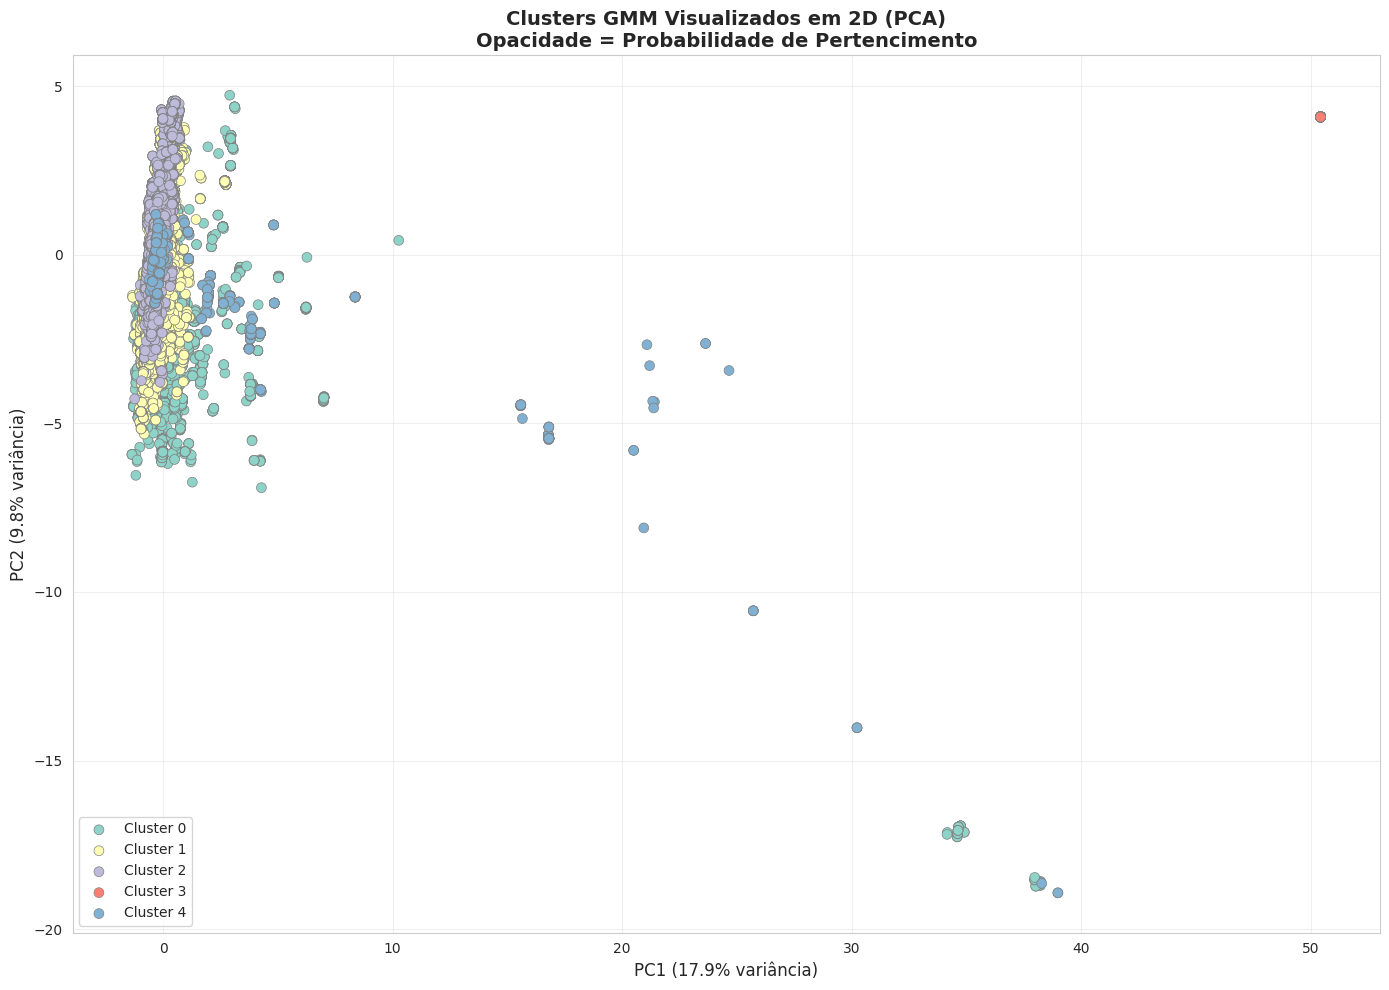


✓ Gráfico salvo: gmm_clusters_pca_2d.png


In [51]:
# Visualizar clusters com intensidade baseada em probabilidade
fig, ax = plt.subplots(figsize=(14, 10))

colors = plt.cm.Set3(range(K_optimal))
for cluster_id in range(K_optimal):
    mask = cluster_labels == cluster_id

    # Usar probabilidade como alpha (transparência)
    probs = cluster_probs[mask, cluster_id]

    scatter = ax.scatter(
        X_pca_2d[mask, 0],
        X_pca_2d[mask, 1],
        c=[colors[cluster_id]],
        alpha=probs * 0.8 + 0.2,  # Alpha proporcional à probabilidade
        s=50,
        edgecolors="gray",
        linewidth=0.5,
        label=f"Cluster {cluster_id}",
    )

ax.set_xlabel(
    f"PC1 ({pca_viz.explained_variance_ratio_[0] * 100:.1f}% variância)", fontsize=12
)
ax.set_ylabel(
    f"PC2 ({pca_viz.explained_variance_ratio_[1] * 100:.1f}% variância)", fontsize=12
)
ax.set_title(
    "Clusters GMM Visualizados em 2D (PCA)\nOpacidade = Probabilidade de Pertencimento",
    fontsize=14,
    fontweight="bold",
)
ax.legend(loc="best", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("gmm_clusters_pca_2d.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✓ Gráfico salvo: gmm_clusters_pca_2d.png")
